In [ ]:
from typing import TypedDict
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from langchain_core.prompts.chat import ChatPromptTemplate
import time

from dotenv import load_dotenv

load_dotenv()

llm = ChatOpenAI(model="gpt-4o",temperature=1)

class WritingState(TypedDict):
    draft: str
    reviews: list[str]
    review_mode: str
    approved: bool
    revision_count: int
    max_count: int
    rejection_reasons: list[str]

workflow = StateGraph(WritingState)

def generate_draft(state: WritingState):
    if state["revision_count"] > 0:
        instruction = f"Rewrite this draft incorporating: {state['rejection_reasons'][-1]}"
    else:
        instruction = "Create an engaging headline for a tech blog post about AI ethics, be bold on your writing."
    
    prompt = ChatPromptTemplate.from_template(f"""
    {instruction}. Current revision: {state["revision_count"]+1}
    Previous attempts: {state["reviews"]}
    """)
    
    chain = prompt | llm | (lambda x: x.content)
    
    new_draft = chain.invoke({
        "instruction": instruction,
        "revision_count": state["revision_count"],
        "previous_drafts": state.get("reviews", [])
    })
    
    return {
        "draft": new_draft,
        "revision_count": state["revision_count"] + 1
    }

def review(state: WritingState):
    draft = state["draft"]
    issues = []
    
    if state["review_mode"] != "Human":
        if len(draft) > 80:
            issues.append("Too long")
        if not any(word in draft.lower() for word in ["ai", "ethical"]):
            issues.append("Missing keywords")
        if "!" in draft:
            issues.append("Overly sensational")
    else:
        print(draft)
        time.sleep(0.5)
        human_review = input("Insert your review:")
        if human_review:
            issues.append(human_review)
    
    return {
        "reviews": state["reviews"] + [draft],
        "rejection_reasons": issues if issues else [],
        "approved": len(issues) == 0,
    }

def approval_gate(state: WritingState):
    """Final validation with state-based routing"""
    if state["approved"]:
        print("\n✅ Approved Draft:", state["draft"])
        return 
    
    print(f"\n⚠️ Rejected (Attempt {state['revision_count']}): {state['rejection_reasons']}")
    print(f"Rejected draft: {state['draft']}")
    
    if state["revision_count"] >= 3:
        print("❌ Maximum revisions reached!")

        return 
    

workflow.add_node("drafter", generate_draft)
workflow.add_node("review", review)
workflow.add_node("approval", approval_gate)

def route_after_approval(state):
    if state["approved"] or state["revision_count"] >= state["max_count"]:
        return END
    return "drafter"

workflow.add_edge("drafter", "review")
workflow.add_edge("review", "approval")
workflow.add_conditional_edges(
    "approval",
    route_after_approval,
    {"drafter": "drafter", END: END}
)

workflow.set_entry_point("drafter")

compiled_workflow = workflow.compile()

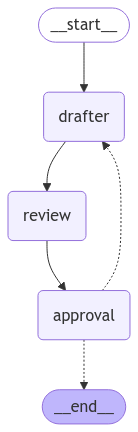

In [2]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        compiled_workflow.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
state = compiled_workflow.invoke({
    "draft": "",
    "reviews": [],
    "review_mode": "",
    "approved": False,
    "revision_count": 0,
    "max_count": 3,
    "rejection_reasons": [],
    "current_step": "draft"
})

print("\n📝 Final State:")
print(f"Drafts Generated: {len(state['reviews'])}")
print(f"Revision Attempts: {state['revision_count']}")
print(f"Approved: {state['approved']}")
if not state["approved"]:
    print("Rejection Reasons:", state['rejection_reasons'])


⚠️ Rejected (Attempt 1): ['Too long']
Rejected draft: "Beyond the Algorithm: Unmasking the Bold Ethical Dilemmas in Artificial Intelligence"

✅ Approved Draft: "Beyond the Algorithm: Unveiling AI's Ethical Challenges"

📝 Final State:
Drafts Generated: 2
Revision Attempts: 2
Approved: True


In [ ]:
state = compiled_workflow.invoke({
    "draft": "",
    "reviews": [],
    "review_mode": "Human",
    "approved": False,
    "revision_count": 0,
    "max_count": 3,
    "rejection_reasons": [],
    "current_step": "draft"
})

print("\n📝 Final State:")
print(f"Drafts Generated: {len(state['reviews'])}")
print(f"Revision Attempts: {state['revision_count']}")
print(f"Approved: {state['approved']}")
if not state["approved"]:
    print("Rejection Reasons:", state['rejection_reasons'])

"Unleashing the Beast: Navigating the Treacherous Waters of AI Ethics!"

⚠️ Rejected (Attempt 1): ['Too emotional']
Rejected draft: "Unleashing the Beast: Navigating the Treacherous Waters of AI Ethics!"
"Finding Balance: Navigating the Complexities of AI Ethics"

⚠️ Rejected (Attempt 2): ['Please make it more technial']
Rejected draft: "Finding Balance: Navigating the Complexities of AI Ethics"
"Refining Equilibrium: Addressing the Intricacies of Ethical Considerations in Artificial Intelligence Systems (Technical Revision 3)"

⚠️ Rejected (Attempt 3): ['Too damn long']
Rejected draft: "Refining Equilibrium: Addressing the Intricacies of Ethical Considerations in Artificial Intelligence Systems (Technical Revision 3)"
❌ Maximum revisions reached!

📝 Final State:
Drafts Generated: 3
Revision Attempts: 3
Approved: False
Rejection Reasons: ['Too damn long']
